### Net for Signed MNIST Dataset

In [6]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

### Loading The Dataset

In [2]:
class SignMNISTDataset(Dataset):
    def __init__(self,file):
        self.data = pd.read_csv(file)
        self.X = self.data.iloc[:, 1:].values.astype('float32') / 255.0
        self.y = self.data.iloc[:, 0].values.astype('int64')

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        img = torch.tensor(self.X[idx]).view(1,28,28)
        label = torch.tensor(self.y[idx])
        return img,label

train_file = "./data/sign_mnist_train.csv"
test_file = "./data/sign_mnist_test.csv"

train_data = SignMNISTDataset(train_file)
test_dataset = SignMNISTDataset(test_file)

train_data_size = len(train_data) - 7172
cv_data_size = 7172
train_dataset , cv_dataset = random_split(train_data,[train_data_size,cv_data_size])

print("Whole Training Data Size:",len(train_data))
print("\nAfter Splitting:\n\tTraining Data Size:",len(train_dataset))
print("\tCross Validation Test Data Size:",len(cv_dataset))
print("\nTest Dataset Size:",len(test_dataset))

train_dataloader = DataLoader(train_dataset,batch_size = 64,shuffle = True)
cv_dataloader = DataLoader(cv_dataset)
test_dataloader = DataLoader(test_dataset)

label_map = {}
for i in range(97,97+25):
    if i == 106 : continue
    label_map[i-97] = chr(i-32)

print("Label Map:",label_map)

Whole Training Data Size: 27455

After Splitting:
	Training Data Size: 20283
	Cross Validation Test Data Size: 7172

Test Dataset Size: 7172
Label Map: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}


### Visualizing The Dataset

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


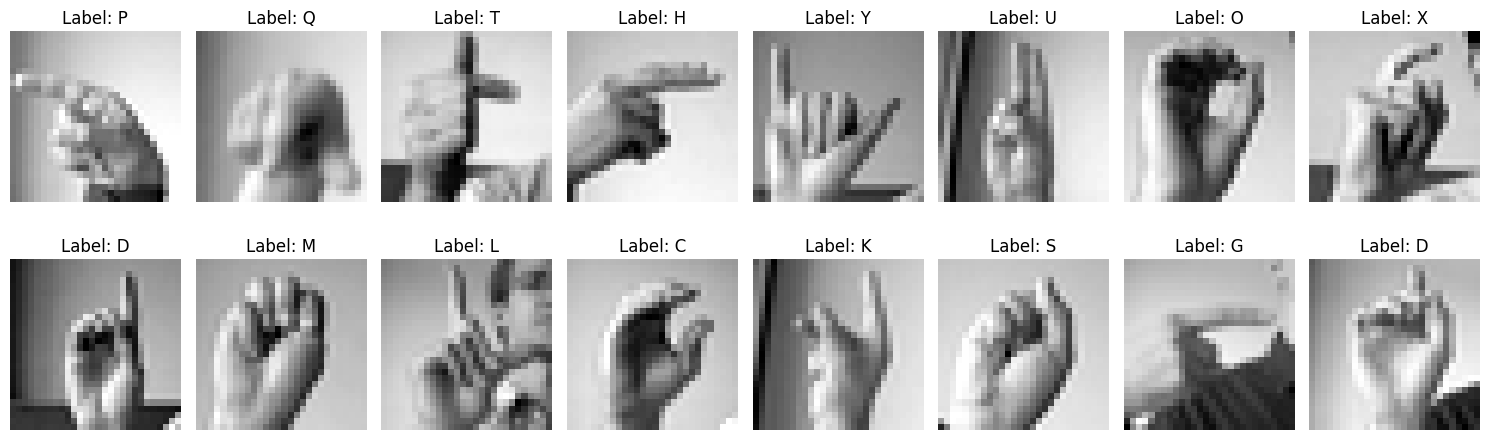

In [3]:
train_features, train_labels = next(iter(train_dataloader))

fig, axes = plt.subplots(2, 8, figsize=(15, 5))  # 2 rows, 8 columns = 16 images
axes = axes.flatten()  # flatten 2D axes array to 1D for easy indexing

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

for i in range(16):
    img = train_features[i].squeeze()
    label = train_labels[i].item()  # convert tensor to Python int
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Label: {label_map[label]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Model

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size_2)
        self.l3 = nn.Linear(hidden_size_2, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

# Hyperparameters
input_size = 784 # 28x28
hidden_size = 1024
hidden_size_2 = 512
num_classes = 25
num_epochs = 100
batch_size = 256
learning_rate = 0.00075

model = NeuralNet(input_size, hidden_size, hidden_size_2, num_classes).to(device)

# Loss
criterion = torch.nn.CrossEntropyLoss()

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

### Training

>> Epoch [5] Average Loss: 0.4557
>> Epoch [10] Average Loss: 0.0767
>> Epoch [15] Average Loss: 0.0144
>> Epoch [20] Average Loss: 0.0215
>> Epoch [25] Average Loss: 0.0026
>> Epoch [30] Average Loss: 0.0090
>> Epoch [35] Average Loss: 0.0019
>> Epoch [40] Average Loss: 0.0376
>> Epoch [45] Average Loss: 0.0611
>> Epoch [50] Average Loss: 0.0056
>> Epoch [55] Average Loss: 0.0015
>> Epoch [60] Average Loss: 0.0013
>> Epoch [65] Average Loss: 0.0006
>> Epoch [70] Average Loss: 0.0713
>> Epoch [75] Average Loss: 0.0005
>> Epoch [80] Average Loss: 0.0650
>> Epoch [85] Average Loss: 0.0006
>> Epoch [90] Average Loss: 0.0641
>> Epoch [95] Average Loss: 0.0005
>> Epoch [100] Average Loss: 0.0014


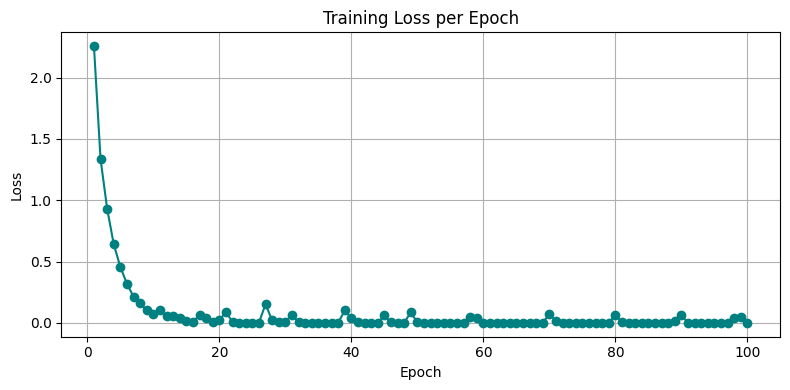

In [22]:
epoch_losses = []
n_total_steps = len(train_dataloader)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass and loss calculation
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        
        # if (i+1) % 500 == 0:
        #     print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

    avg_loss = running_loss / n_total_steps
    epoch_losses.append(avg_loss)
    if (epoch+1)%5==0 : print(f'>> Epoch [{epoch+1}] Average Loss: {avg_loss:.4f}')

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', color='teal')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

### Validating Performance On Training Set

In [23]:
# Test the model: we don't need to compute gradients
with torch.no_grad():
    n_correct = 0
    n_samples = len(train_dataloader.dataset)

    for images, labels in train_dataloader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} train images: {100*acc} %')

Accuracy of the network on the 20283 train images: 100.0 %


### Validating Performance On Cross Validation Set

In [24]:
with torch.no_grad():
    n_correct = 0
    n_samples = len(cv_dataloader.dataset)

    for images, labels in cv_dataloader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} CV test images: {100*acc} %')

Accuracy of the network on the 7172 CV test images: 100.0 %


### Validating Performance On Test Set

In [25]:
with torch.no_grad():
    n_correct = 0
    n_samples = len(test_dataloader.dataset)

    for images, labels in test_dataloader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} Test images: {100*acc} %')

Accuracy of the network on the 7172 Test images: 80.39598438371445 %


In [26]:
### Saving Weights
torch.save(model.state_dict(), "model_weights.pth")